# eCommerce Product Recommendation - Part 3

# 1. Load Feature Data

In [35]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from imblearn.pipeline import Pipeline 
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import keras
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
cd /content/drive/MyDrive/Laioffer/csv_files/RecSys_eComm/

[Errno 2] No such file or directory: '/content/drive/MyDrive/Laioffer/csv_files/RecSys_eComm/'
/content


In [39]:
ls

drive/  model.png  sample_data/


In [40]:
model_all_data = pd.read_csv('/content/drive/MyDrive/RecSys_eComm/model_all_data.csv')

In [41]:
model_all_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label,user_product__total_orders,user_product__add_to_cart_order_mean,...,product__most_hod,product__days_since_prior_order_mean,product__aisle_id,product__department_id,user__order_count,user__product_count,user__days_since_prior_order_mean,user__reordered_mean,user__most_dow,user__most_hod
0,152610,43772,22,6,8,10.0,152610_43772,0,2,3.0,...,12,12.008565,83,4,26,408,10.953804,0.375,6,12
1,152610,37886,22,6,8,10.0,152610_37886,0,2,3.5,...,14,11.489362,53,16,26,408,10.953804,0.375,6,12
2,152610,37215,22,6,8,10.0,152610_37215,0,1,5.0,...,13,11.490066,98,7,26,408,10.953804,0.375,6,12
3,152610,3164,22,6,8,10.0,152610_3164,0,1,7.0,...,8,10.000000,98,7,26,408,10.953804,0.375,6,12
4,152610,26910,22,6,8,10.0,152610_26910,0,1,8.0,...,10,5.800000,98,7,26,408,10.953804,0.375,6,12


In [42]:
unique_key = ['user_id', 'product_id']

raw_features = ['order_number',
                     'order_dow',
                     'order_hour_of_day',
                     'days_since_prior_order',
                     'user_product__total_orders',
                     'user_product__add_to_cart_order_mean',
                     'user_product__reordered_mean',
                     'user_product__most_dow',
                     'user_product__most_hod',
                     'product__total_orders',
                     'product__add_to_cart_order_mean',
                     'product__total_users',
                     'product__reordered_mean',
                     'product__most_dow',
                     'product__most_hod',
                     'product__days_since_prior_order_mean',
                     'user__order_count',
                     'user__product_count',
                     'user__days_since_prior_order_mean',
                     'user__reordered_mean',
                     'user__most_dow',
                     'user__most_hod',
                     'product__aisle_id',
                     'product__department_id',
                     ]
                   
label = ['label']

In [43]:
model_all_data = model_all_data[unique_key + raw_features + label]

In [44]:
model_all_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__most_dow,...,product__days_since_prior_order_mean,user__order_count,user__product_count,user__days_since_prior_order_mean,user__reordered_mean,user__most_dow,user__most_hod,product__aisle_id,product__department_id,label
0,152610,43772,22,6,8,10.0,2,3.0,0.5,5,...,12.008565,26,408,10.953804,0.375,6,12,83,4,0
1,152610,37886,22,6,8,10.0,2,3.5,0.5,6,...,11.489362,26,408,10.953804,0.375,6,12,53,16,0
2,152610,37215,22,6,8,10.0,1,5.0,0.0,6,...,11.490066,26,408,10.953804,0.375,6,12,98,7,0
3,152610,3164,22,6,8,10.0,1,7.0,0.0,6,...,10.000000,26,408,10.953804,0.375,6,12,98,7,0
4,152610,26910,22,6,8,10.0,1,8.0,0.0,6,...,5.800000,26,408,10.953804,0.375,6,12,98,7,0


# 2. Feature Data Analysis & Tranformation

2.1. Label Ratio

In [45]:
label_count = model_all_data.label.value_counts()
print("Negative label count: ", label_count[0])
print("Positive label count: ", label_count[1])
print("Positive label rate is {:.2f}%".format(
      label_count[1] / (label_count[0] + label_count[1]) * 100) )

Negative label count:  306866
Positive label count:  22940
Positive label rate is 6.96%


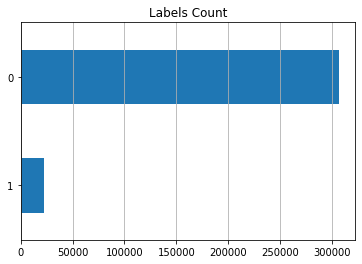

In [46]:
ax = label_count.sort_values().plot(kind='barh', title='Labels Count')
ax.grid(axis="x")

2.2. Null value check

In [47]:
model_all_data.isna().sum()

user_id                                     0
product_id                                  0
order_number                                0
order_dow                                   0
order_hour_of_day                           0
days_since_prior_order                  21350
user_product__total_orders                  0
user_product__add_to_cart_order_mean        0
user_product__reordered_mean                0
user_product__most_dow                      0
user_product__most_hod                      0
product__total_orders                       0
product__add_to_cart_order_mean             0
product__total_users                        0
product__reordered_mean                     0
product__most_dow                           0
product__most_hod                           0
product__days_since_prior_order_mean      726
user__order_count                           0
user__product_count                         0
user__days_since_prior_order_mean           0
user__reordered_mean              

2.3. Categorical Feature Transformation


In [48]:
# One-hot encoding for the `product__department_id` feature.
model_all_data = pd.concat(
    [model_all_data.drop('product__department_id',axis=1),
     pd.get_dummies(model_all_data["product__department_id"],
                    prefix='product__department_id_')],
                     axis=1)

# 3. Split Dataset to Train, Validation and Test

In order to do model training, model selection and evaluation, we split `model_all_data` to three parts: train, validation, test.

In [49]:
# We randomly select 20% users as test data. 
# The remaining data will be used as train & validation data.
test_user_ids = model_all_data.user_id.drop_duplicates().sample(frac=0.2)

train_validation_data = model_all_data[~model_all_data.user_id.isin(test_user_ids)]
test_data = model_all_data[model_all_data.user_id.isin(test_user_ids)]

In [50]:
model_all_data.shape

(329806, 47)

In [51]:
train_validation_data.shape

(262347, 47)

In [52]:
test_data.shape

(67459, 47)

# 4. Model Selection with Cross Validation

4.1. Model Selection with All Features

In [53]:
train_validation_data_x = train_validation_data.drop(['user_id', 'product_id', 'label'],axis=1)
train_validation_data_y = train_validation_data['label']

In [54]:
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    GradientBoostingClassifier(),
    ]

  # |--------------train-val(80)---------------| ---test(20)---|
  #  1      2       3         4         5
  #  1      2       3         4         5
  #  1      2       3         4         5
  #  1      2       3         4         5
  #  1      2       3         4         5


In [55]:
def build_ml_pipeline(classifier): 
  steps = list()
  steps.append(('fillnan', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0)))
  steps.append(('downSample', RandomUnderSampler()))
  steps.append(('scaler', MinMaxScaler()))
  steps.append(('model', classifier))
  pipeline = Pipeline(steps=steps) #Pipeline: Sequentially apply a list of transforms, sampling, and a final estimator. 
  return pipeline

In [56]:
# 如何解释 model performance (or model selection)
# 1. Accuracy -> F1 score
# 2. Latency -> 代表模型复杂度
# 3. 可解释性

# 解决办法 -> multi-tasks, 确保模型虽然复杂但是精确度高。具体情况具体分析。

for classifier in classifiers:
  pipeline = build_ml_pipeline(classifier)
  %time scores = cross_val_score(pipeline, train_validation_data_x, train_validation_data_y, cv=5, scoring='f1')
  print(classifier.__class__.__name__, ': F1 value is %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))
  print('==============')

CPU times: user 7.88 s, sys: 3.34 s, total: 11.2 s
Wall time: 6.86 s
LogisticRegression : F1 value is 37.670 (0.644)
CPU times: user 4.22 s, sys: 98.9 ms, total: 4.32 s
Wall time: 4.23 s
DecisionTreeClassifier : F1 value is 34.345 (1.666)
CPU times: user 33.9 s, sys: 58.2 ms, total: 34 s
Wall time: 33.9 s
RandomForestClassifier : F1 value is 35.774 (0.854)
CPU times: user 7.32 s, sys: 73.9 ms, total: 7.39 s
Wall time: 7.39 s
LGBMClassifier : F1 value is 37.546 (0.990)
CPU times: user 21.8 s, sys: 45.6 ms, total: 21.8 s
Wall time: 22.7 s
XGBClassifier : F1 value is 36.744 (0.866)
CPU times: user 1min 5s, sys: 29.2 ms, total: 1min 5s
Wall time: 1min 6s
GradientBoostingClassifier : F1 value is 37.350 (0.737)


4.2. Feature Selection


### We use LGBMClassifier because it has relative high F1, short time, and it has explainability feature_importance and let I explain

In [57]:
# Use all data - "train_validation_data_x" - 重算一次，没有 hyperparameter tuning。

pipeline = build_ml_pipeline(LGBMClassifier())
pipeline.fit(train_validation_data_x, train_validation_data_y)

Pipeline(steps=[('fillnan', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('downSample', RandomUnderSampler()),
                ('scaler', MinMaxScaler()), ('model', LGBMClassifier())])

In [58]:
pipeline.steps[3][1]

LGBMClassifier()

In [59]:
importances = pipeline.steps[3][1].feature_importances_
feature_names=train_validation_data_x.columns.tolist()

In [60]:
df_importances = pd.DataFrame(
    {"feature":feature_names, "importance":importances}).sort_values("importance", ascending=False)
top15_features = df_importances.head(15)    

In [61]:
# Only use the selected top 15 features in our training data.
train_validation_data_x_select_features = train_validation_data_x[top15_features['feature']]

In [62]:
top15_features

,feature,importance
16,user__order_count,351
4,user_product__total_orders,301
0,order_number,279
19,user__reordered_mean,189
12,product__reordered_mean,186
18,user__days_since_prior_order_mean,182
15,product__days_since_prior_order_mean,153
17,user__product_count,149
9,product__total_orders,148
5,user_product__add_to_cart_order_mean,146


4.3. Train Neural Network Model

In [63]:
# Feed forward neural network
def create_model():
    model = keras.Sequential([
        ### layer input
        keras.layers.Dense(30, input_dim=15, activation='relu'),
        ###  layer 1
        keras.layers.Dense(15, activation='relu'),
        ###  layer 2
        keras.layers.Dense(5, activation='relu'),
        ### layer output
        keras.layers.Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [64]:
# wrap the model using the function you created
NN_model = KerasClassifier(build_fn=create_model, epochs=64, batch_size=32, verbose=0)

In [65]:
keras_model = create_model()

In [66]:
print(keras_model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 30)                480       
                                                                 
 dense_25 (Dense)            (None, 15)                465       
                                                                 
 dense_26 (Dense)            (None, 5)                 80        
                                                                 
 dense_27 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,031
Trainable params: 1,031
Non-trainable params: 0
_________________________________________________________________
None


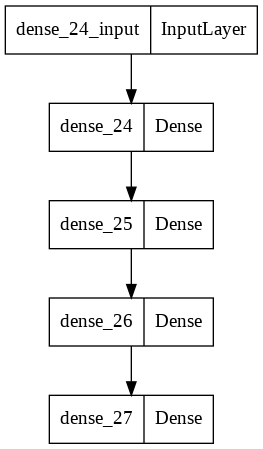

In [67]:
plot_model(keras_model)

4.4. (Optional) Model Selection with Selected Top 15 Features including Neural Network Model

In [68]:
# Add our neural network model to our classifiers list.
classifiers.append(NN_model)

In [69]:
for classifier in classifiers:
  pipeline = build_ml_pipeline(classifier)
  %time scores = cross_val_score(pipeline, train_validation_data_x_select_features, train_validation_data_y, cv=5, scoring='f1')
  print(classifier.__class__.__name__, ': F1 value is %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))
  print('==============')


  # NN_model：
  # F1 = 34.941, slightly lower than gradient boost of 35.177. But, the variance of the NN_model F1 is 1.284.

CPU times: user 3.48 s, sys: 2.21 s, total: 5.7 s
Wall time: 3.32 s
LogisticRegression : F1 value is 37.243 (1.975)
CPU times: user 2.7 s, sys: 95.2 ms, total: 2.8 s
Wall time: 2.73 s
DecisionTreeClassifier : F1 value is 34.365 (1.509)
CPU times: user 35.6 s, sys: 105 ms, total: 35.7 s
Wall time: 35.8 s
RandomForestClassifier : F1 value is 36.290 (0.871)
CPU times: user 5.25 s, sys: 56.2 ms, total: 5.31 s
Wall time: 5.3 s
LGBMClassifier : F1 value is 37.692 (0.852)
CPU times: user 11.6 s, sys: 39.9 ms, total: 11.7 s
Wall time: 11.6 s
XGBClassifier : F1 value is 36.912 (0.780)
CPU times: user 45.7 s, sys: 29 ms, total: 45.7 s
Wall time: 45.6 s
GradientBoostingClassifier : F1 value is 37.380 (0.866)
1640/1640 [==============================] - 2s 1ms/step
CPU times: user 10min 41s, sys: 45.5 s, total: 11min 26s
Wall time: 10min 6s
KerasClassifier : F1 value is 37.812 (2.898)


# 6. Hyper-parameter tuning for LightGBM Classifier

In [101]:
# optional 
sample_user_ids = train_validation_data.user_id.drop_duplicates().sample(frac=0.05) # we only use 5% data for training because of colab's limited calculation ability 
train_validation_data_sample = train_validation_data[train_validation_data.user_id.isin(sample_user_ids)]

In [102]:
train_validation_data_sample_x = train_validation_data_sample.drop(['user_id', 'product_id', 'label'],axis=1)[top15_features['feature']]
train_validation_data_sample_y = train_validation_data_sample['label']

In [108]:
param_grid = {
    'model__learning_rate':[0.13,0.15,0.17], #default is 0.1
    'model__n_estimators':[100], #num of tree we build for each round, default is 100
    'model__max_depth':[10,12,14],
    'model__num_leaves':[31,35], #default is 31, max number of leaves in one tree
    'model__subsample':[0.8,1], #each tree takes x% of total sample
    'model__feature_fraction':[0.8,1], # each tree see x% total features 
    'model__reg_lambda':[0], #default is 0
    'model__reg_alpha':[0], #default is 0
    'model__objectve': ['binary'], # Default: ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier
    'model__max_bin': [255], # default = 255, max number of bins the feature value will be bucketed in (histogram based grouping!)
}

In [109]:
grid = GridSearchCV(build_ml_pipeline(LGBMClassifier()), cv=5, param_grid=param_grid, scoring='f1')
grid.fit(train_validation_data_sample_x, train_validation_data_sample_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fillnan',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('downSample', RandomUnderSampler()),
                                       ('scaler', MinMaxScaler()),
                                       ('model', LGBMClassifier())]),
             param_grid={'model__feature_fraction': [0.8, 1],
                         'model__learning_rate': [0.13, 0.15, 0.17],
                         'model__max_bin': [255],
                         'model__max_depth': [10, 12, 14],
                         'model__n_estimators': [100],
                         'model__num_leaves': [31, 35],
                         'model__objectve': ['binary'], 'model__reg_alpha': [0],
                         'model__reg_lambda': [0],
                         'model__subsample': [0.8, 1]},
             scoring='f1')

In [111]:
print("Best F1 value is %.3f" % grid.best_score_)
print("Params are %s" % grid.best_params_)

Best F1 value is 0.357
Params are {'model__feature_fraction': 0.8, 'model__learning_rate': 0.15, 'model__max_bin': 255, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__num_leaves': 35, 'model__objectve': 'binary', 'model__reg_alpha': 0, 'model__reg_lambda': 0, 'model__subsample': 0.8}


# 7. Train the final GradientBoostingClassifier

7.1. Train the final model with all training+validation data and the best hyper-parameters.

In [113]:
#use the best parameter combination just returned above
pipeline = build_ml_pipeline(LGBMClassifier(
    feature_fraction=0.8,
    learning_rate=0.15,
    max_bin=255,
    max_depth=10,
    n_estimators = 100,
    num_leaves = 35
))

pipeline.fit(train_validation_data_x_select_features, train_validation_data_y)

Pipeline(steps=[('fillnan', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('downSample', RandomUnderSampler()),
                ('scaler', MinMaxScaler()),
                ('model',
                 LGBMClassifier(feature_fraction=0.8, learning_rate=0.15,
                                max_bin=255, max_depth=10, num_leaves=35))])

In [114]:
importances = pipeline.steps[3][1].feature_importances_
feature_names=train_validation_data_x_select_features.columns.tolist()
df_importances = pd.DataFrame(
    {"feature":feature_names, "importance":importances}).sort_values("importance", ascending=False)
df_importances.head(15)

,feature,importance
0,user__order_count,362
3,user__reordered_mean,324
2,order_number,317
1,user_product__total_orders,251
9,user_product__add_to_cart_order_mean,250
5,user__days_since_prior_order_mean,242
7,user__product_count,234
6,product__days_since_prior_order_mean,225
4,product__reordered_mean,222
11,days_since_prior_order,185


# 8. Evaluate model on Test Data

8.1. Predict product reorder on Test Data

In [115]:
test_data_x_selected_features = test_data.drop(['user_id', 'product_id', 'label'],axis=1)[top15_features['feature']]
test_data_y = test_data['label']

In [116]:
predict_y = pipeline.predict(test_data_x_selected_features)

In [117]:
df_output = pd.DataFrame(
    {"user_id":test_data.user_id, "product_id":test_data.product_id, "predict":predict_y, "label":test_data.label})   

In [118]:
df_output.head()

,user_id,product_id,predict,label
914,179438,43772,0,0
915,179438,46886,0,0
916,179438,6414,1,1
917,179438,16797,0,1
918,179438,42356,0,0


In [119]:
predict_y_prob = pipeline.predict_proba(test_data_x_selected_features)[:,1]

8.2. Analyze classification result

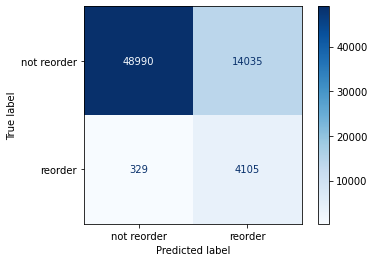

In [120]:
plot_confusion_matrix(pipeline, test_data_x_selected_features, test_data_y,
                      display_labels=["not reorder","reorder"],cmap=plt.cm.Blues)

In [121]:
acc = accuracy_score(test_data_y, predict_y)
f1 = f1_score(test_data_y, predict_y)
pre = precision_score(test_data_y, predict_y)
rec = recall_score(test_data_y, predict_y)
auc = roc_auc_score(test_data_y, predict_y_prob)

In [122]:
print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 36.3693%
ROC AUC : 91.8804%
Accuracy : 78.7071%
Precision : 22.6295%
Recall : 92.5801%
